In [20]:
import importlib
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import multi_input_lsm
importlib.reload(multi_input_lsm)
from multi_input_lsm import MultiInputLSTM

import preprocessing
importlib.reload(preprocessing)
from preprocessing import Preprocessing

import data_collection
importlib.reload(data_collection)
from data_collection import DataCollection

import data_plotter
importlib.reload(data_plotter)
from data_plotter import DataPlotter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### DATA COLLECTION #####

In [21]:
# Define parameters for data collection
tickers = ["GOOGL"]
start_date = "2000-01-01"
data_path = "../data"
end_date = datetime.today().date()

# Initialize DataCollection and fetch data
data_collector = DataCollection(tickers, start_date, end_date, folder_path=data_path)
data_collector.fetch_and_save_all()

[*********************100%***********************]  1 of 1 completed

Data saved to ../data\GOOGL_data.csv


##### DATA PREPARATION #####

In [22]:
# Parameters for preprocessing
sequence_length = 100
split_ratio = 0.8
batch_size = 32

# Initialize Preprocessing and preprocess data
pp = Preprocessing(folder_path=data_path, split_ratio=split_ratio, sequence_length=sequence_length)
x_open_train, x_high_train, x_low_train, x_close_train, x_volume_train, y_train, y_train_dates,x_open_test, x_high_test, x_low_test, x_close_test, x_volume_test, y_test, y_test_dates = pp.preprocess_pipeline()

# Convert data to PyTorch tensors and move to the appropriate device
x_open_train_tensor = torch.tensor(x_open_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_high_train_tensor = torch.tensor(x_high_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_low_train_tensor = torch.tensor(x_low_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_close_train_tensor = torch.tensor(x_close_train, dtype=torch.float32).unsqueeze(-1).to(device)
x_volume_train_tensor = torch.tensor(x_volume_train, dtype=torch.float32).unsqueeze(-1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

x_open_test_tensor = torch.tensor(x_open_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_high_test_tensor = torch.tensor(x_high_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_low_test_tensor = torch.tensor(x_low_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_close_test_tensor = torch.tensor(x_close_test, dtype=torch.float32).unsqueeze(-1).to(device)
x_volume_test_tensor = torch.tensor(x_volume_test, dtype=torch.float32).unsqueeze(-1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(x_open_train_tensor, x_high_train_tensor, x_low_train_tensor, x_close_train_tensor, x_volume_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_open_test_tensor, x_high_test_tensor, x_low_test_tensor, x_close_test_tensor, x_volume_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##### MODEL SETUP #####

In [23]:
# Define model hyperparameters
input_size = 5  # Number of input features (['Open', 'High', 'Low', 'Close', 'Volume'])
output_size = 5  # Predicting 5 values for the next day
hidden_size = 50  # Number of hidden units in LSTM
learning_rate = 0.001 # Learning rate for optimizer
num_layers = 4 # Number of LSTM layers
dropout = 0.2 # Dropout rate for regularization

# Instantiate the model and move to the appropriate device
model = MultiInputLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,dropout=dropout).to(device)

# Define loss function and optimize
criterion = nn.MSELoss() # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer with weight decay

##### TRAINING THE MODEL #####

In [24]:
# Number of epochs for training
num_epochs = 50

# Set model to training mode
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0

    # Iterate over batches of training data
    for x_open, x_high, x_low, x_close, x_volume, y in train_loader:
        optimizer.zero_grad() # Zero the gradients
        outputs = model.forward(x_open, x_high, x_low, x_close, x_volume) # Forward pass
        loss = criterion(outputs, y) # Compute loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights
        running_loss += loss.item() # Accumulate loss
    
    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.6f}")

Epoch 1/50, Loss: 0.018936
Epoch 2/50, Loss: 0.001413
Epoch 3/50, Loss: 0.001240
Epoch 4/50, Loss: 0.001086
Epoch 5/50, Loss: 0.001013
Epoch 6/50, Loss: 0.001011
Epoch 7/50, Loss: 0.000928
Epoch 8/50, Loss: 0.000957
Epoch 9/50, Loss: 0.000895
Epoch 10/50, Loss: 0.000938
Epoch 11/50, Loss: 0.000857
Epoch 12/50, Loss: 0.000848
Epoch 13/50, Loss: 0.000836
Epoch 14/50, Loss: 0.000765
Epoch 15/50, Loss: 0.000755
Epoch 16/50, Loss: 0.000730
Epoch 17/50, Loss: 0.000776
Epoch 18/50, Loss: 0.000727
Epoch 19/50, Loss: 0.000716
Epoch 20/50, Loss: 0.000702
Epoch 21/50, Loss: 0.000708
Epoch 22/50, Loss: 0.000680
Epoch 23/50, Loss: 0.000669
Epoch 24/50, Loss: 0.000673
Epoch 25/50, Loss: 0.000693
Epoch 26/50, Loss: 0.000670
Epoch 27/50, Loss: 0.000666
Epoch 28/50, Loss: 0.000633
Epoch 29/50, Loss: 0.000635
Epoch 30/50, Loss: 0.000653
Epoch 31/50, Loss: 0.000657
Epoch 32/50, Loss: 0.000670
Epoch 33/50, Loss: 0.000616
Epoch 34/50, Loss: 0.000619
Epoch 35/50, Loss: 0.000630
Epoch 36/50, Loss: 0.000631
E

##### EVALUATING THE MODEL #####

Test Loss: 0.13976

Comparison of MSE and Variance for each feature:
Open: MSE = 5.30164, Variance = 0.10168
  -> The model does not outperform a mean-based prediction for Open.
High: MSE = 4.98063, Variance = 0.09563
  -> The model does not outperform a mean-based prediction for High.
Low: MSE = 5.76715, Variance = 0.10446
  -> The model does not outperform a mean-based prediction for Low.
Close: MSE = 5.80307, Variance = 0.10110
  -> The model does not outperform a mean-based prediction for Close.
Volume: MSE = 0.00313, Variance = 0.00157
  -> The model does not outperform a mean-based prediction for Volume.
Date: 2021-04-05
Sample prediction (original scale): 93.97, 95.67, 91.58, 93.11, 24086440.00
Actual values (original scale): 107.36, 111.45, 107.26, 110.95, 48510000.00
--------------------------------------------------
Date: 2021-04-06
Sample prediction (original scale): 95.26, 97.07, 92.86, 94.46, 26335398.00
Actual values (original scale): 110.55, 111.40, 110.09, 110.46, 35240

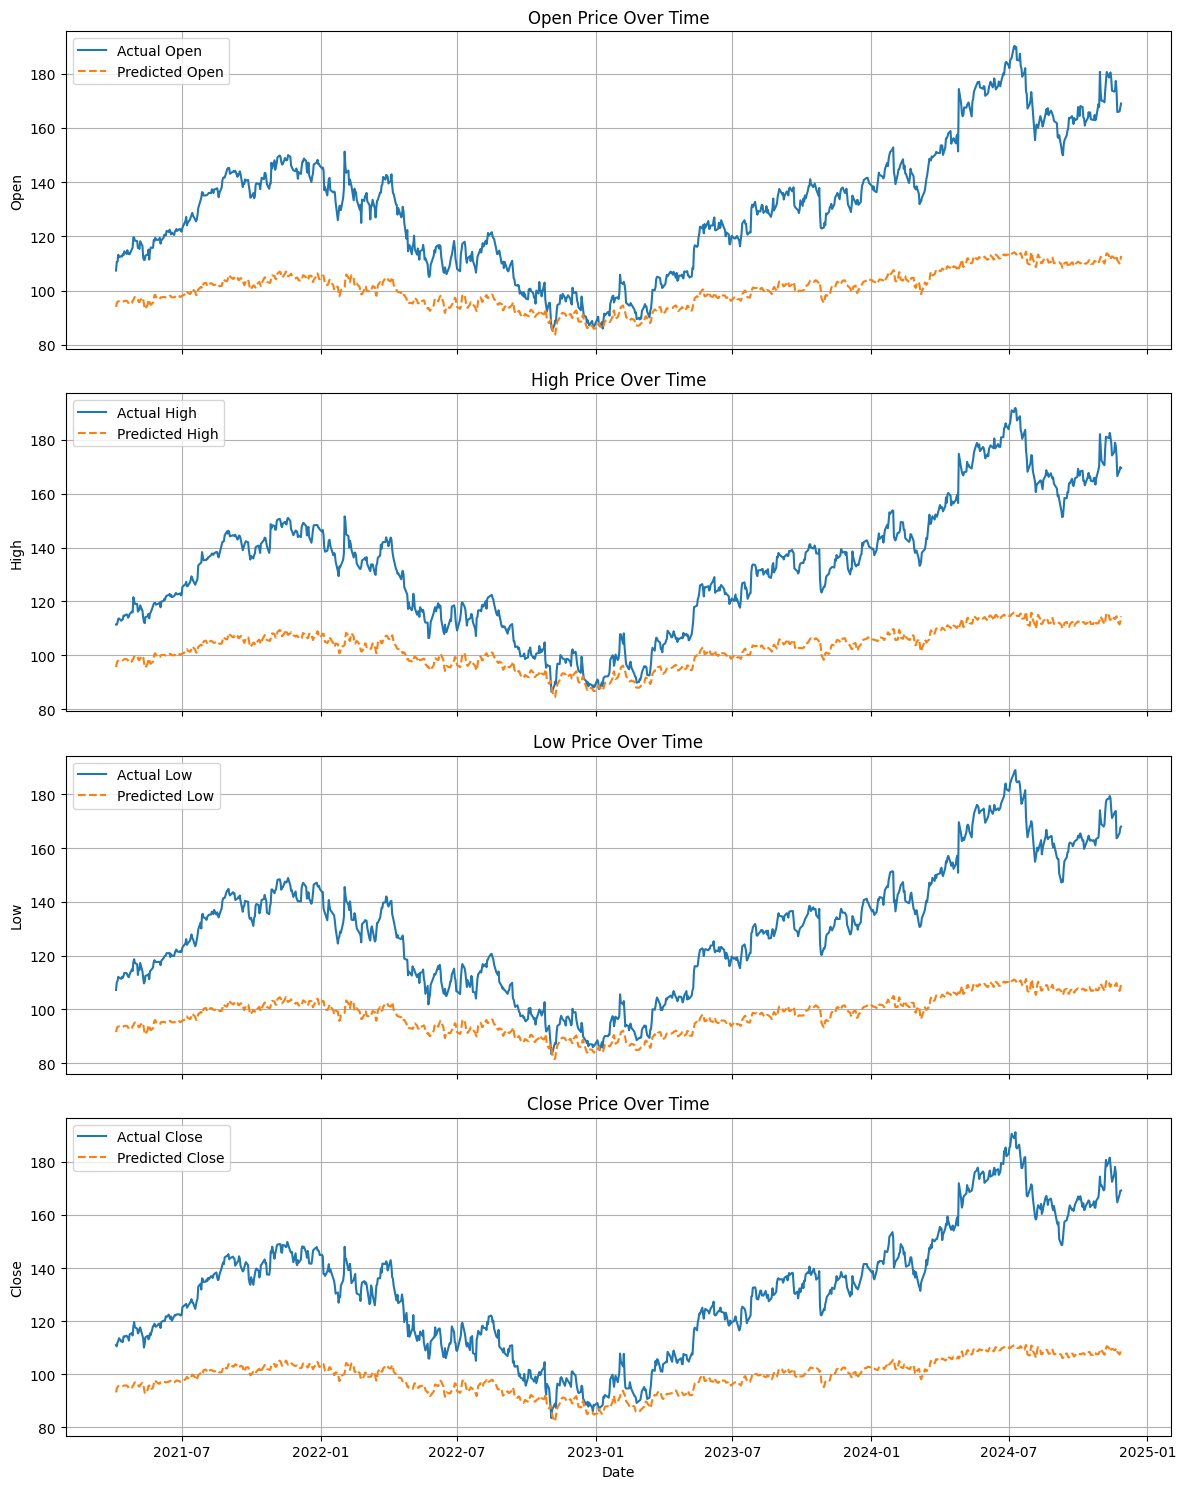

MSE Loss: 0.13976
Variance: 0.41586
The model performs better than a mean-based prediction.


In [26]:
model.eval()
test_loss = 0.0
predictions = []
actuals = []
mse_per_feature = [0.0] * output_size  # MSE for each feature
variance_per_feature = [0.0] * output_size  # Variance for each feature

# Disable gradient computation for evaluation
with torch.no_grad():
    for x_open, x_high, x_low, x_close, x_volume, y in test_loader:
        output = model.forward(x_open, x_high, x_low, x_close, x_volume) # Forward pass
        loss = criterion(output, y) # Compute loss
        test_loss += loss.item() # Accumulate loss
        predictions.append(output.cpu()) # Store predictions
        actuals.append(y.cpu()) # Store actual values
        
        # Compute MSE and variance for each feature
        for i in range(output_size):
            mse_per_feature[i] += nn.functional.mse_loss(output[:, i], y[:, i], reduction='sum').item()
            variance_per_feature[i] += torch.sum((y[:, i] - torch.mean(y[:, i]))**2).item()

# Calculate average test loss
test_loss /= len(test_loader) 
print(f"Test Loss: {test_loss:.5f}")

# Average MSE and Variance over the dataset
num_samples = len(test_loader)
mse_per_feature = [mse / num_samples for mse in mse_per_feature]
variance_per_feature = [var / num_samples for var in variance_per_feature]

# Post-process predictions and actuals for inverse scaling
predictions = torch.cat(predictions).numpy()
actuals = torch.cat(actuals).numpy()

# Inverse transform OHLC using the scaler from preprocessing
predictions_original = pp.scaler.inverse_transform(predictions)
actuals_original = pp.scaler.inverse_transform(actuals)

# Print and compare MSE and Variance for each feature
feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']
print("\nComparison of MSE and Variance for each feature:")
for i, (mse, var) in enumerate(zip(mse_per_feature, variance_per_feature)):
    print(f"{feature_names[i]}: MSE = {mse:.5f}, Variance = {var:.5f}")
    if mse < var:
        print(f"  -> The model performs better than a mean-based prediction for {feature_names[i]}.")
    else:
        print(f"  -> The model does not outperform a mean-based prediction for {feature_names[i]}.")
    print("-" * 50)

# Print sample predictions and actual values
for i in range(5):
    print(f"Date: {y_test_dates[i]}")
    prediction_str = ", ".join([f"{x:.2f}" for x in predictions_original[i]])
    actual_str = ", ".join([f"{x:.2f}" for x in actuals_original[i]])
    print(f"Sample prediction (original scale): {prediction_str}")
    print(f"Actual values (original scale): {actual_str}")
    print("-" * 50)

# Plotting results
plotter = DataPlotter()
df_results = plotter.create_results_dataframe(y_test_dates, actuals_original, predictions_original)
plotter.plot_results(df_results)

variance = np.var(actuals)

# Print MSE loss and variance
print(f"MSE Loss: {test_loss:.5f}")
print(f"Variance: {variance:.5f}")

# Compare MSE loss with variance
if test_loss < variance:
    print("The model performs better than a mean-based prediction.")
else:
    print("The model does not perform better than a mean-based prediction.")